In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import utils


In [6]:
gram_matrix = utils.gram_matrix
Normalization = utils.Normalization

## 'content loss function' and 'style loss function'
# content loss is the mean square error between feature maps of input and content images

class CL(nn.Module):
    def __init__(self, target):
        super(CL, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

# style loss is the mean square error between gram matrix of input and style images
class SL(nn.Module):
    def __init__(self, target):
        super(SL, self).__init__()
        self.target = gram_matrix(target).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

## Generating the 'Neural Style Transfer' Model
def nst_model(content_img, style_img):
    vgg = models.vgg19(pretrained=True).features.eval()
        
    normalization = Normalization(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

    content_img = content_img.detach()
    style_img = style_img.detach()
    content_losses = []
    style_losses = []

    model = nn.Sequential(normalization)
    i = 0
    for name, layer in vgg._modules.items():
        
        if name in ['0','2','5','7','10','12','14','16','19','21','23','25','28','30','32','34']:
            model.add_module('conv_{}'.format(i),layer)
            i += 1

        elif name in ['3','8','13','15','17','24','26','31','33','35']:
            layer = nn.ReLU(inplace=False)
            model.add_module('relu_{}'.format(i),layer)
            i += 1

        elif name in ['4','9','18','27','36']:
            model.add_module('maxpool_{}'.format(i),layer)
            i += 1

        elif name in ['1','6','11','20','29']:
            layer = nn.ReLU(inplace=False)
            model.add_module('relu_{}'.format(i),layer)
            style_target = model(style_img)
            style_loss = SL(style_target)
            style_losses.append(style_loss)
            model.add_module('styleloss_{}'.format(i),style_loss)
            i += 1
            
        elif name == '22':
            layer = nn.ReLU(inplace=False)
            model.add_module('relu_{}'.format(i),layer)
            content_target = model(content_img)
            content_loss = CL(content_target)
            content_losses.append(content_loss)
            model.add_module('contentloss_{}'.format(i),content_loss)
            i += 1 
            

    return model, style_losses, content_losses

Step : [0]
Style Loss : 48.468281 Content Loss: 0.000000
Step : [50]
Style Loss : 4.235721 Content Loss: 2.239512
Step : [100]
Style Loss : 2.834131 Content Loss: 1.957434
Step : [150]
Style Loss : 2.358103 Content Loss: 1.884776
Step : [200]
Style Loss : 2.182773 Content Loss: 1.851825
Step : [250]
Style Loss : 2.098782 Content Loss: 1.833127
Step : [300]
Style Loss : 2.043192 Content Loss: 1.821537
time cost: 485.20812344551086


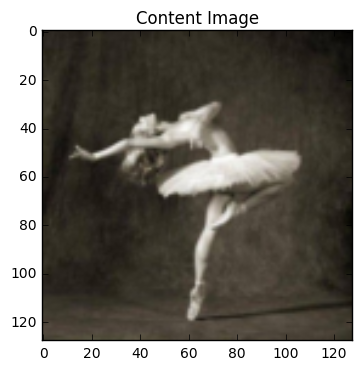

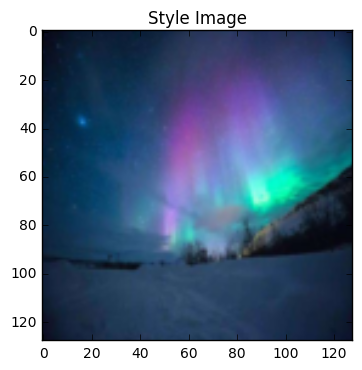

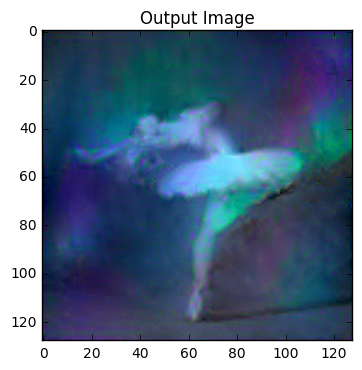

In [16]:
import torch
import torch.nn as nn

import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import model
import utils

import argparse
from time import time

nst = nst_model
loader = utils.loader
imshow = utils.imshow


def main(content_img,style_img,size,steps,c_weight,s_weight):
#content_img,style_img,size,steps,c_weight,s_weight

    content_img, style_img = loader(content_img, style_img, size = size)
    input_img = content_img.clone() # just noise array is fine


    model, style_losses, content_losses  = nst(content_img, style_img)

    optimizer = optim.LBFGS([input_img.requires_grad_()],lr = 1.2)

    step = [0]
    while step[0] <= steps:
        def closure():
            input_img.data.clamp_(0, 1)
            optimizer.zero_grad()
            output = model(input_img)

            cl = 0
            sl = 0
            i = 0
            for c_loss in content_losses:
                cl += c_loss.loss * c_weight[0]
            for s_loss in style_losses:
                sl += s_loss.loss * s_weight[i]
                i += 1

            loss = cl + sl
            loss.backward()
            
            if step[0] % 50 == 0:
                print('Step : {}'. format(step))
                print('Style Loss : {:3f} Content Loss: {:3f}'.format(
                    sl.item(), cl.item()))

            step[0] += 1

            return loss

        optimizer.step(closure)

    input_img.data.clamp_(0,1)
    return input_img

    imshow(content_img, title = 'Input image')
    plt.show()
def imshow(image, title = None,save_path = None):
    image = image.clone()
    image = image.squeeze(0)
    pil = transforms.ToPILImage()
    target_img_PIL = pil(image)
    plt.figure()
    plt.imshow(target_img_PIL)
    if title is not None:
        plt.title(title)
    if save_path is not None:
        target_img_PIL.save(save_path) 
    plt.pause(1)
if __name__ == "__main__":

    content_weights = [1e0]
    style_weight = [1e8/n for n in [64,128,256,512,512]]
    start = time()
    output = main(content_img='./images/dancing.jpg',style_img='images/oruora1.jpg',size=128,steps=300,c_weight=content_weights,s_weight=style_weight )
    print('time cost:', time()-start)
    plt.figure()
    imshow(output, title = 'Output Image',save_path = './results/nst_dancing_oruora1.jpg')
    plt.pause(5)
    plt.show()